In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/deeplearningproject4/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/deeplearningproject4/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/deeplearningproject4/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/deeplearningproject4/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject4/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject4/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject4/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
import os
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


# Custom IMDB Dataset class
class IMDBDataset(Dataset):
    def __init__(self, root_dir, vocab, max_len=200):
        self.root_dir = root_dir
        self.vocab = vocab
        self.max_len = max_len
        self.data = []
        for label in ['pos', 'neg']:
            label_dir = os.path.join(root_dir, label)
            label_idx = 1 if label == 'pos' else 0
            for filename in os.listdir(label_dir):
                if filename.endswith('.txt'):
                    with open(os.path.join(label_dir, filename), 'r', encoding='utf-8') as f:
                        text = f.read()
                    indices = self.text_to_tensor(text)
                    self.data.append((indices, label_idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        return text, label

    def text_to_tensor(self, text):
        words = text.lower().split()[:self.max_len]
        indices = [self.vocab.get(word, 1) for word in words]  # 1 is <unk>
        if len(indices) < self.max_len:
            indices += [0] * (self.max_len - len(indices))  # 0 is <pad>
        return torch.tensor(indices, dtype=torch.long)

# Download and extract IMDB dataset
data_url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
data_path = './data/aclImdb_v1.tar.gz'
extracted_path = './data/aclImdb'

if not os.path.exists(extracted_path):
    os.makedirs('./data', exist_ok=True)
    print("Downloading IMDB dataset...")
    urllib.request.urlretrieve(data_url, data_path)
    print("Extracting IMDB dataset...")
    with tarfile.open(data_path, 'r:gz') as tar:
        tar.extractall('./data')
    os.remove(data_path)  # Clean up tar file

# Build vocabulary from training data
vocab_size = 10000
max_len = 200
word2idx = {'<pad>': 0, '<unk>': 1}

train_dir = os.path.join(extracted_path, 'train')
for label in ['pos', 'neg']:
    label_dir = os.path.join(train_dir, label)
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(label_dir, filename), 'r', encoding='utf-8') as f:
                text = f.read()
            for word in text.lower().split():
                if word not in word2idx and len(word2idx) < vocab_size:
                    word2idx[word] = len(word2idx)

# Load datasets
train_dataset = IMDBDataset(os.path.join(extracted_path, 'train'), word2idx, max_len)
test_dataset = IMDBDataset(os.path.join(extracted_path, 'test'), word2idx, max_len)

# Train/validation split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a sample
sample_text, sample_label = train_dataset[0]
sample_words = [k for k, v in word2idx.items() if v in sample_text[:20]]
print(f'Sample Label: {"Positive" if sample_label == 1 else "Negative"}')
print(f'Sample Text (first 20 words): {sample_words}')

Extracting IMDB dataset...


/var/folders/5k/98s1prfj6zjgkscx_x64q9cm0000gn/T/ipykernel_52606/3834158288.py:56: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('./data')


Sample Label: Positive
Sample Text (first 20 words): ['<unk>', 'are', 'of', 'is', 'the', 'and', 'i', "it's", 'which', 'ever', "i've", 'one', 'think', 'movies', 'seen', 'book', 'greatest', 'made,', 'better,']


In [4]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        output, (hidden, cell) = self.lstm(embedded)  # hidden: [1, batch_size, hidden_dim]
        return self.fc(hidden.squeeze(0))  # [batch_size, output_dim]

# Hyperparameters
embedding_dim = 32
hidden_dim = 50
output_dim = 1
model = LSTMNet(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

Epoch [1/10], Train Loss: 0.6929, Val Loss: 0.6913
Epoch [2/10], Train Loss: 0.6871, Val Loss: 0.6788
Epoch [3/10], Train Loss: 0.6712, Val Loss: 0.6595
Epoch [4/10], Train Loss: 0.6387, Val Loss: 0.7421
Epoch [5/10], Train Loss: 0.6845, Val Loss: 0.6906
Epoch [6/10], Train Loss: 0.6485, Val Loss: 0.6300
Epoch [7/10], Train Loss: 0.6336, Val Loss: 0.6721
Epoch [8/10], Train Loss: 0.5774, Val Loss: 0.6025
Epoch [9/10], Train Loss: 0.5713, Val Loss: 0.6901
Epoch [10/10], Train Loss: 0.6197, Val Loss: 0.5910


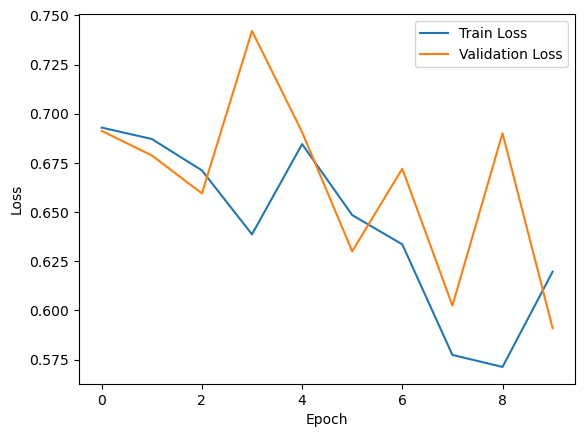

In [5]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(texts)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(texts)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 65.31%
